In [105]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/remote-work-health-impact-survey-2025/post_pandemic_remote_work_health_impact_2025.csv


In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Exploration

In [107]:
# Set visualization style
plt.style.use('seaborn')
%matplotlib inline

In [108]:
# Load data 
data = pd.read_csv('/kaggle/input/remote-work-health-impact-survey-2025/post_pandemic_remote_work_health_impact_2025.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Survey_Date              3157 non-null   object
 1   Age                      3157 non-null   int64 
 2   Gender                   3157 non-null   object
 3   Region                   3157 non-null   object
 4   Industry                 3157 non-null   object
 5   Job_Role                 3157 non-null   object
 6   Work_Arrangement         3157 non-null   object
 7   Hours_Per_Week           3157 non-null   int64 
 8   Mental_Health_Status     2358 non-null   object
 9   Burnout_Level            3157 non-null   object
 10  Work_Life_Balance_Score  3157 non-null   int64 
 11  Physical_Health_Issues   2877 non-null   object
 12  Social_Isolation_Score   3157 non-null   int64 
 13  Salary_Range             3157 non-null   object
dtypes: int64(4), object(10)
me

In [109]:
# Summary statistics for numerical columns
numerical_cols = ['Age', 'Hours_Per_Week', 'Work_Life_Balance_Score', 'Social_Isolation_Score']
print("\nSummary Statistics for Numerical Columns:")
print(data[numerical_cols].describe())


Summary Statistics for Numerical Columns:
               Age  Hours_Per_Week  Work_Life_Balance_Score  \
count  3157.000000     3157.000000              3157.000000   
mean     43.732024       49.904973                 2.996516   
std      12.661095        8.897699                 1.163307   
min      22.000000       35.000000                 1.000000   
25%      33.000000       42.000000                 2.000000   
50%      44.000000       50.000000                 3.000000   
75%      55.000000       57.000000                 4.000000   
max      65.000000       65.000000                 5.000000   

       Social_Isolation_Score  
count             3157.000000  
mean                 2.704783  
std                  1.188887  
min                  1.000000  
25%                  2.000000  
50%                  3.000000  
75%                  4.000000  
max                  5.000000  


In [110]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Survey_Date                  0
Age                          0
Gender                       0
Region                       0
Industry                     0
Job_Role                     0
Work_Arrangement             0
Hours_Per_Week               0
Mental_Health_Status       799
Burnout_Level                0
Work_Life_Balance_Score      0
Physical_Health_Issues     280
Social_Isolation_Score       0
Salary_Range                 0
dtype: int64


## 2. EDA

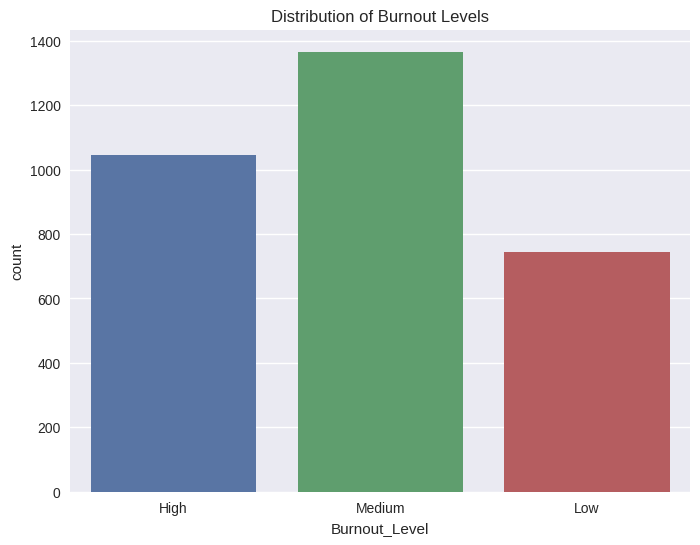

In [111]:
# Distribution of target variable (Burnout_Level)
plt.figure(figsize=(8, 6))
sns.countplot(x='Burnout_Level', data=data)
plt.title('Distribution of Burnout Levels')
plt.show()

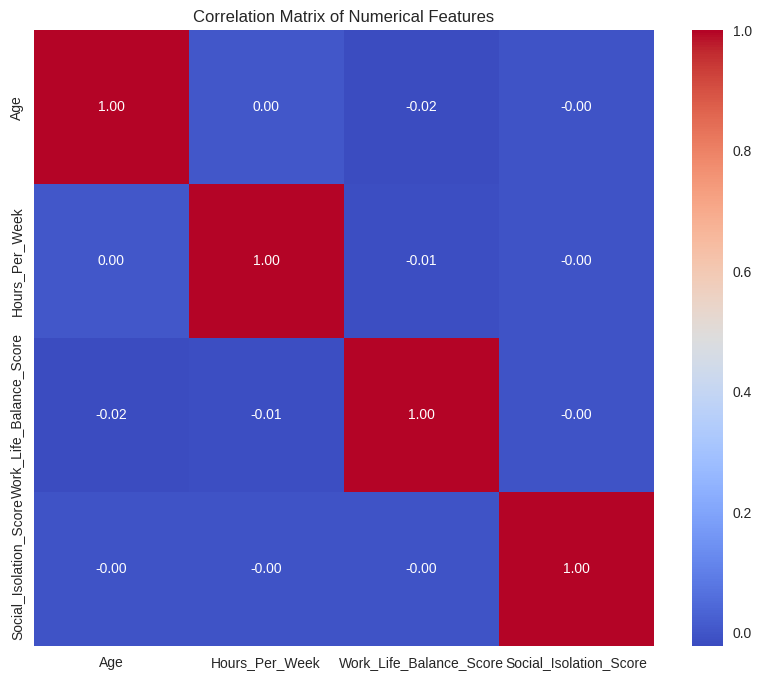

In [112]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

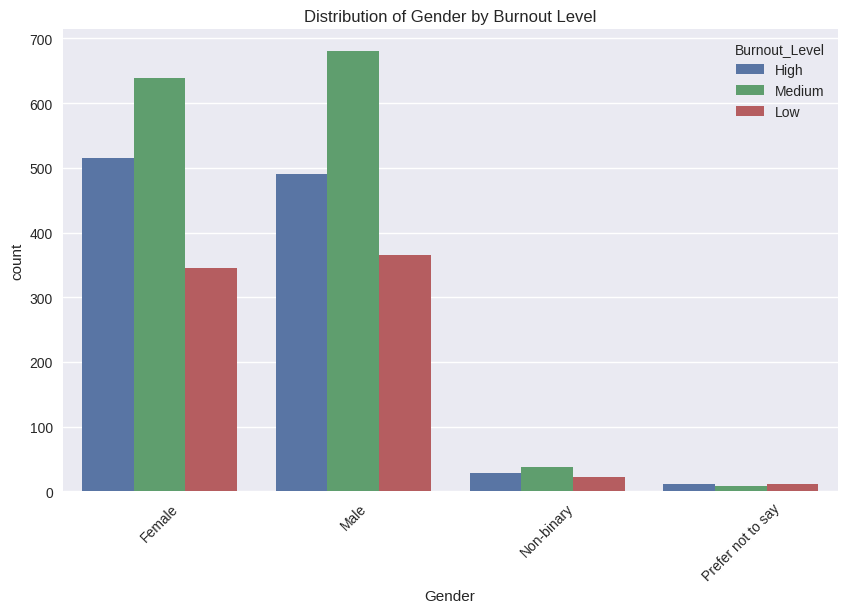

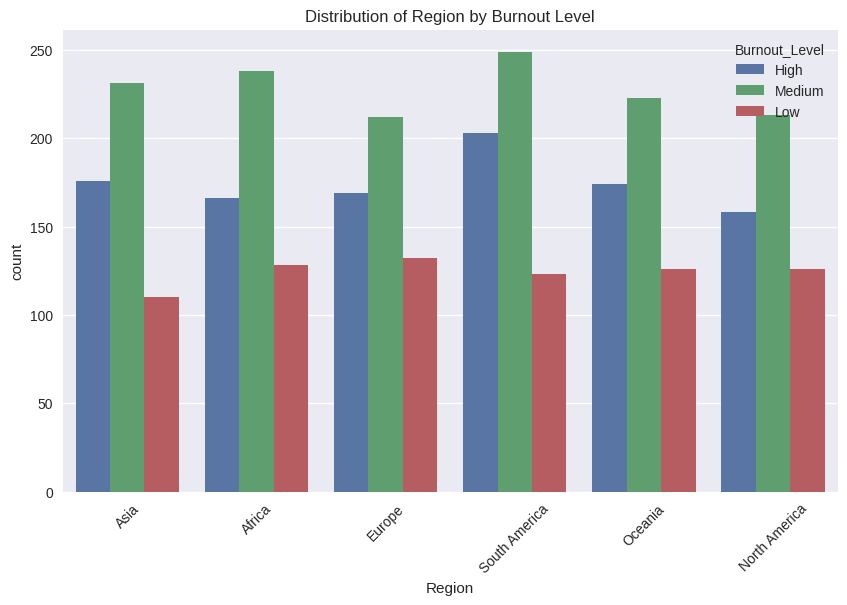

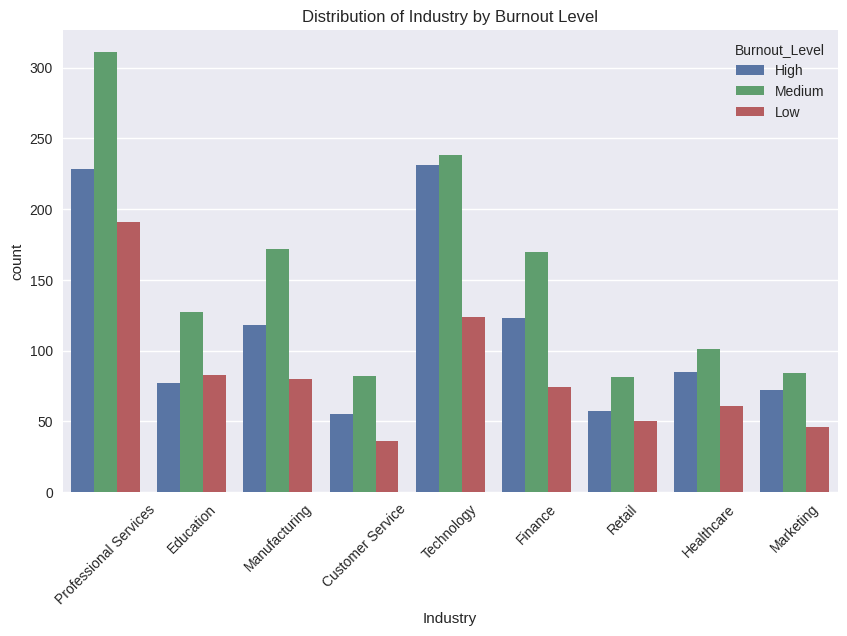

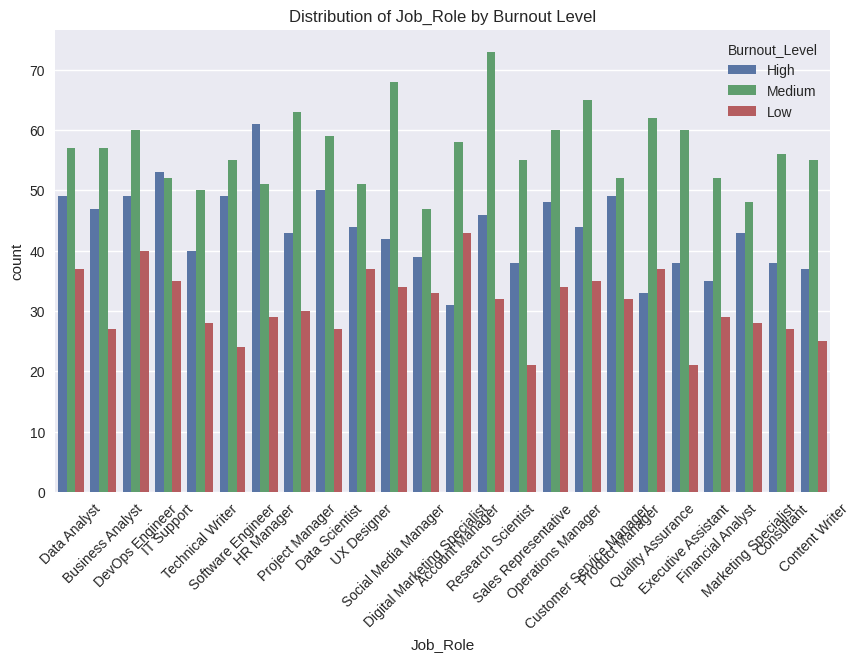

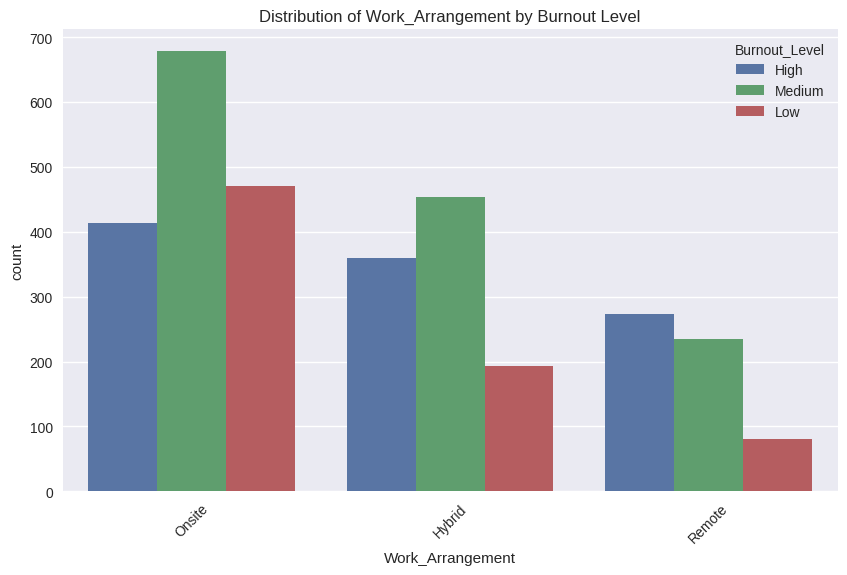

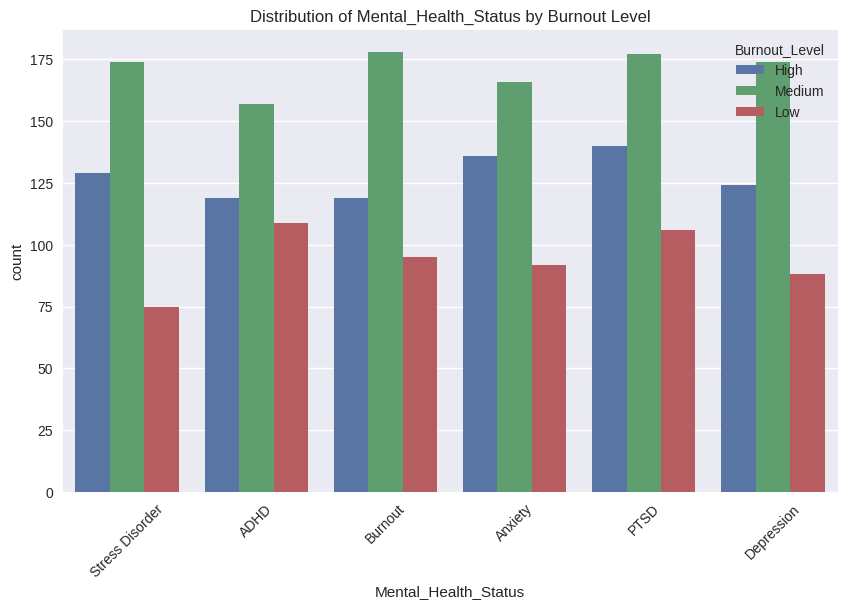

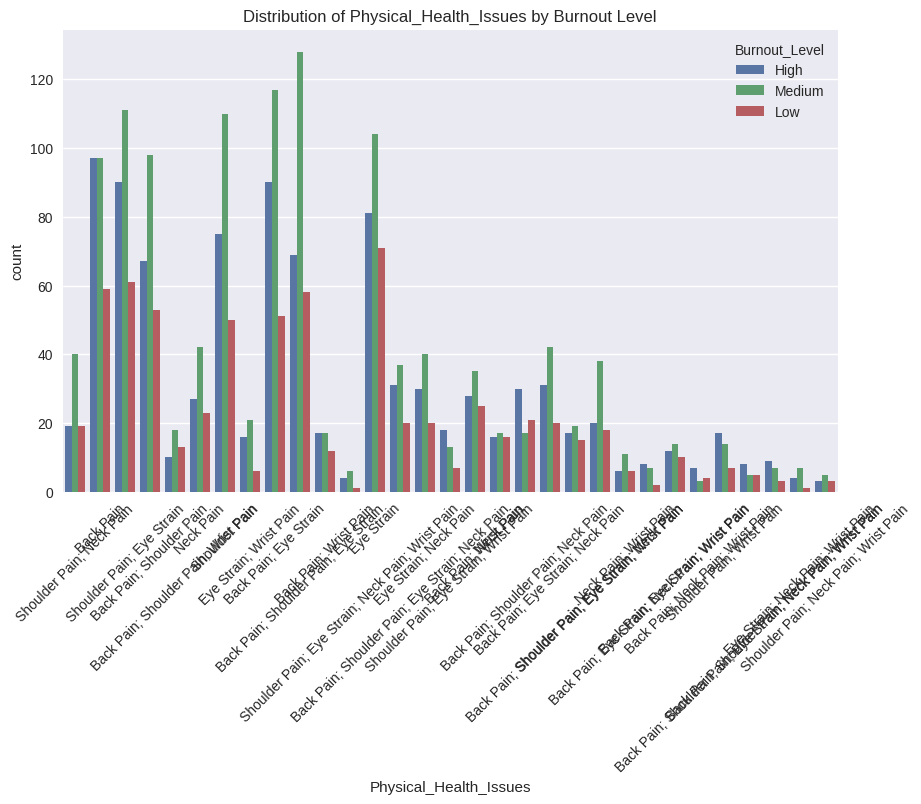

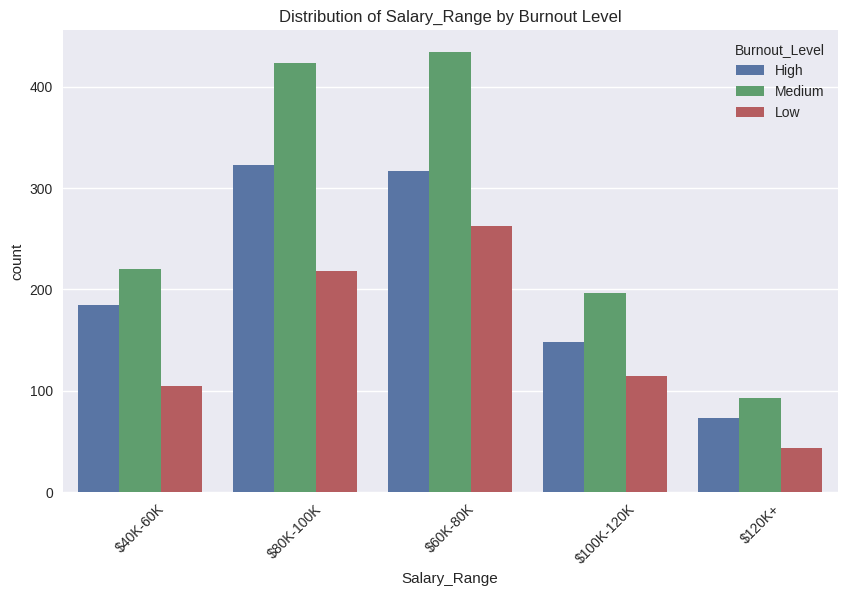

In [113]:
# Distribution of categorical variables
categorical_cols = ['Gender', 'Region', 'Industry', 'Job_Role', 'Work_Arrangement', 'Mental_Health_Status', 'Physical_Health_Issues', 'Salary_Range']
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='Burnout_Level', data=data)
    plt.title(f'Distribution of {col} by Burnout Level')
    plt.xticks(rotation=45)
    plt.show()

#### **Observations**

- **Missing Values:** Significant missing data in Mental_Health_Status (799 missing, or about 25.3%) and Physical_Health_Issues (280 missing, around8.9%). This will require imputation or exclusion.
- **Numerical Summary:** Age ranges from 22 to 65 (mean 43.73, std 12.66), Hours_Per_Week from 35 to 65 (mean 49.90, std 8.90), Work_Life_Balance_Score from 1 to 5 (mean 2.99, std 1.16), and Social_Isolation_Score from 1 to 5 (mean 2.70, std 1.19). Distributions suggest moderate variability, potential for normalization.
- **Target Distribution:** Burnout_Level shows a class imbalance, with Medium being the most frequent, followed by High and Low (~800). May necessitate techniques like stratified sampling or class weighting during modeling.
- **Work Arrangement Insights:** Onsite work has the highest counts across all burnout levels, with Medium peaking at 650. Remote work shows lower counts, particularly for Low. This could mean a potential association between work arrangement and burnout.
- **Mental Health Status:** Stress Disorder and Depression have the highest counts, with High and Medium burnout levels dominating. This indicates a strong link between mental health conditions and elevated burnout.
- **Salary Range:** Medium burnout is most prevalent across 60K-80K and 80K-100K, while High burnout is notable in 80K-100K. Lower salaries (40K-60K) show a balanced distribution. This points to the presence of income-burnout dynamics.
- **Gender Distribution:** Female and Male categories are well-represented, with Medium burnout leading. Non-binary and Prefer not to say have minimal counts, which limits their predictive power.
- **Region and Industry:** South America and North America show higher Medium burnout, while Professional Services and Technology dominate industry counts, with Medium burnout prevalent.
- **Physical Health Issues:88 Shoulder Pain and Neck Pain are frequent, with Medium burnout leading, suggesting a correlation with physical strain.
- **Job Role:** Diverse roles show similar patterns, with Data Analyst and DevOps Engineer having higher counts, and Medium burnout dominating.
- **Correlation Analysis:** Numerical features (Age, Hours_Per_Week, Work_Life_Balance_Score, Social_Isolation_Score) exhibit weak correlations (all < 0.02). This signifies low multicollinearity and supporting their use as independent predictors.

## 3. Data Preprocessing

In [114]:
# Create a copy of the dataframe for modeling
data_model = data.copy()

In [115]:
# Impute Mental_Health_Status with mode 
mental_imputer = SimpleImputer(strategy='most_frequent')
data_model['Mental_Health_Status'] = mental_imputer.fit_transform(data_model[['Mental_Health_Status']]).ravel()

In [116]:
# Impute Physical_Health_Issues with 'None' where missing
data_model['Physical_Health_Issues'].fillna('None', inplace=True)

In [117]:
# Encode categorical variables
categorical_cols = ['Gender', 'Region', 'Industry', 'Job_Role', 'Work_Arrangement', 
                   'Mental_Health_Status', 'Physical_Health_Issues', 'Salary_Range', 'Burnout_Level']
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    data_model[col] = label_encoders[col].fit_transform(data_model[col])

In [118]:
# Scale numerical features
numerical_cols = ['Age', 'Hours_Per_Week', 'Work_Life_Balance_Score', 'Social_Isolation_Score']
scaler = StandardScaler()
data_model[numerical_cols] = scaler.fit_transform(data_model[numerical_cols])

In [119]:
# Separate features and target
X = data_model.drop(['Burnout_Level', 'Survey_Date'], axis=1)
y = data_model['Burnout_Level']

## 4. Feature Engineeering

In [120]:
# Use original data for Age_Group binning
data_model['Work_Load'] = data_model['Hours_Per_Week'] * data_model['Social_Isolation_Score']
data_model['Health_Stress_Index'] = data_model['Work_Life_Balance_Score'] * data_model['Mental_Health_Status']

In [121]:
# Bin original Age from the unscaled data
data_model['Age_Group'] = pd.cut(data['Age'], bins=[20, 30, 40, 50, 60, 70], labels=[0, 1, 2, 3, 4], include_lowest=True)
data_model['Age_Group'] = data_model['Age_Group'].cat.codes

In [122]:
# Update feature matrix
X = data_model.drop('Burnout_Level', axis=1)
y = data_model['Burnout_Level']

In [123]:
# Display updated dataset info and new feature statistics
print("Updated Dataset Info:")
print(data_model.info())
print("\nSummary Statistics for New Features:")
print(data_model[['Work_Load', 'Health_Stress_Index', 'Age_Group']].describe())

Updated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survey_Date              3157 non-null   object 
 1   Age                      3157 non-null   float64
 2   Gender                   3157 non-null   int64  
 3   Region                   3157 non-null   int64  
 4   Industry                 3157 non-null   int64  
 5   Job_Role                 3157 non-null   int64  
 6   Work_Arrangement         3157 non-null   int64  
 7   Hours_Per_Week           3157 non-null   float64
 8   Mental_Health_Status     3157 non-null   int64  
 9   Burnout_Level            3157 non-null   int64  
 10  Work_Life_Balance_Score  3157 non-null   float64
 11  Physical_Health_Issues   3157 non-null   int64  
 12  Social_Isolation_Score   3157 non-null   float64
 13  Salary_Range             3157 non-null   int64  
 14  Wo

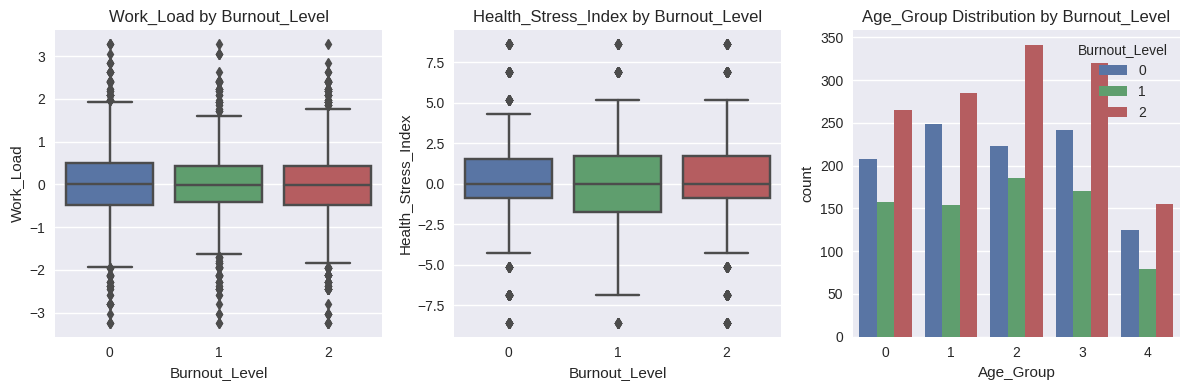

In [124]:
# Visualize new features by Burnout_Level
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.boxplot(x='Burnout_Level', y='Work_Load', data=data_model)
plt.title('Work_Load by Burnout_Level')

plt.subplot(1, 3, 2)
sns.boxplot(x='Burnout_Level', y='Health_Stress_Index', data=data_model)
plt.title('Health_Stress_Index by Burnout_Level')

plt.subplot(1, 3, 3)
sns.countplot(x='Age_Group', hue='Burnout_Level', data=data_model)
plt.title('Age_Group Distribution by Burnout_Level')

plt.tight_layout()
plt.show()

**Visualization Insights:**

- **Work_Load by Burnout_Level:** Boxplots for High, Low, and Medium show overlapping medians near 0 with similar IQRs. High has more positive outliers. This suggests that higher work load may correlate with increased burnout, though the effect is not strong.
- **Health_Stress_Index by Burnout_Level:** Distributions are centered around 0, with Medium and High showing wider IQRs and more outliers. Low has a tighter range, an indication of better balance or lower stress, which could be a key differentiator.
- **Age_Group Distribution by Burnout_Level:** Counts show a balanced spread across age groups, with Medium consistently highest, followed by High and Low. Group 2 (40-50) peaks at around 300 for Medium, while Group 4 (60-70) has the lowest counts. This implies that age may influence burnout patterns, with middle age groups experiencing more Medium burnout.

## 5. Model Selection 

In [125]:
# Drop Survey_Date from the feature matrix
X = data_model.drop(['Burnout_Level', 'Survey_Date'], axis=1)
y = data_model['Burnout_Level']

In [126]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [127]:
# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [128]:
# Predict and evaluate
y_pred = rf_model.predict(X_test)

In [129]:
# Cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

In [130]:
# Print results
print("Feature Importances:")
for feature, importance in zip(X.columns, rf_model.feature_importances_):
    print(f"{feature}: {importance:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nCross-Validation Scores:", cv_scores)
print("Average CV Score:", cv_scores.mean())

Feature Importances:
Age: 0.1018
Gender: 0.0311
Region: 0.0626
Industry: 0.0689
Job_Role: 0.1005
Work_Arrangement: 0.0343
Hours_Per_Week: 0.0966
Mental_Health_Status: 0.0507
Work_Life_Balance_Score: 0.0406
Physical_Health_Issues: 0.0931
Social_Isolation_Score: 0.0450
Salary_Range: 0.0530
Work_Load: 0.1095
Health_Stress_Index: 0.0724
Age_Group: 0.0401

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.28      0.31       209
           1       0.26      0.08      0.12       149
           2       0.41      0.62      0.50       274

    accuracy                           0.38       632
   macro avg       0.34      0.33      0.31       632
weighted avg       0.35      0.38      0.35       632


Cross-Validation Scores: [0.38607595 0.4193038  0.39461173 0.41362916 0.38985737]
Average CV Score: 0.4006956007141568


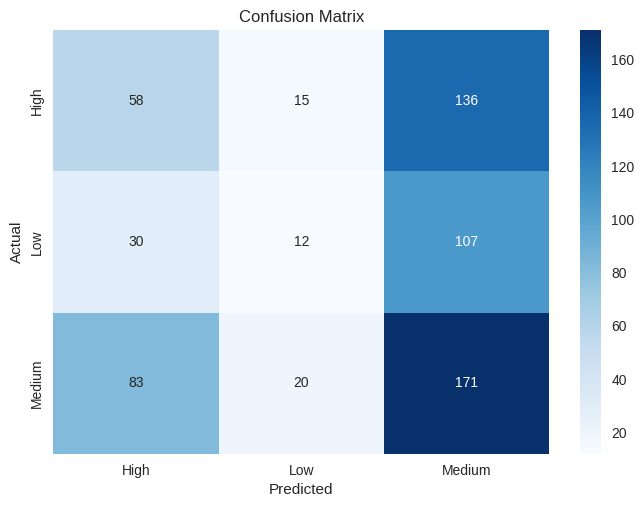

In [131]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['High', 'Low', 'Medium'], yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 6. Model Improvement

In [132]:
# Drop Survey_Date from the feature matrix
X = data_model.drop(['Burnout_Level', 'Survey_Date'], axis=1)
y = data_model['Burnout_Level']

In [133]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [134]:
# Define class weights based on inverse frequency
class_weights = {0: 1.0, 1: 1.5, 2: 0.8}  

In [135]:
# Initialize and train the model with GridSearchCV for hyperparameter tuning
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': [class_weights, 'balanced']
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 1.0, 1: 1.5, 2: 0.8}, 'balanced'],
                         'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1_weighted')

In [136]:
# Best model
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'class_weight': {0: 1.0, 1: 1.5, 2: 0.8}, 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}


In [137]:
# Predict and evaluate
y_pred = best_rf_model.predict(X_test)

In [138]:
# Cross-validation
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='accuracy')

In [139]:
# Print results
print("Feature Importances:")
for feature, importance in zip(X.columns, best_rf_model.feature_importances_):
    print(f"{feature}: {importance:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nCross-Validation Scores:", cv_scores)
print("Average CV Score:", cv_scores.mean())

Feature Importances:
Age: 0.1039
Gender: 0.0283
Region: 0.0615
Industry: 0.0710
Job_Role: 0.0991
Work_Arrangement: 0.0442
Hours_Per_Week: 0.0962
Mental_Health_Status: 0.0472
Work_Life_Balance_Score: 0.0389
Physical_Health_Issues: 0.0941
Social_Isolation_Score: 0.0445
Salary_Range: 0.0494
Work_Load: 0.1093
Health_Stress_Index: 0.0721
Age_Group: 0.0402

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.30      0.32       209
           1       0.27      0.11      0.16       149
           2       0.41      0.58      0.48       274

    accuracy                           0.38       632
   macro avg       0.34      0.33      0.32       632
weighted avg       0.36      0.38      0.35       632


Cross-Validation Scores: [0.38132911 0.41297468 0.3866878  0.35657686 0.39144216]
Average CV Score: 0.3858021224096772


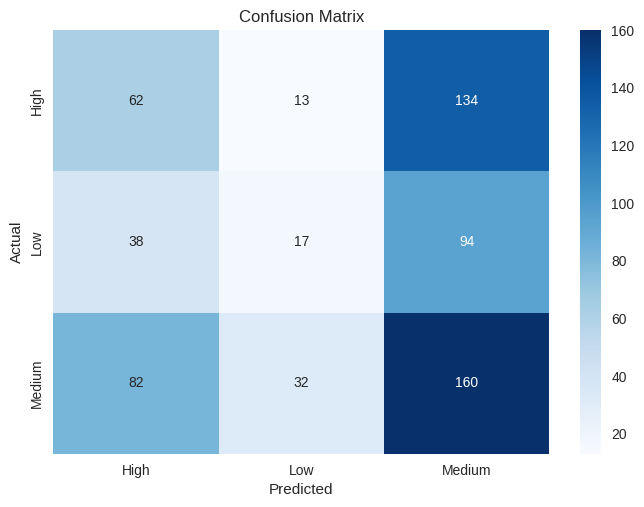

In [140]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['High', 'Low', 'Medium'], yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()